## Challenge : Flower recognition
目標: 以深度學習模型進行模型訓練，辨識照片中的花種。

說明: 資料集共有五種不同種類的花 - 雛菊(daisy)、蒲公英(dandellion)、玫瑰(rose)、向日葵(sunflower)、鬱金香(tulip)



## Kaggle Leaderboard
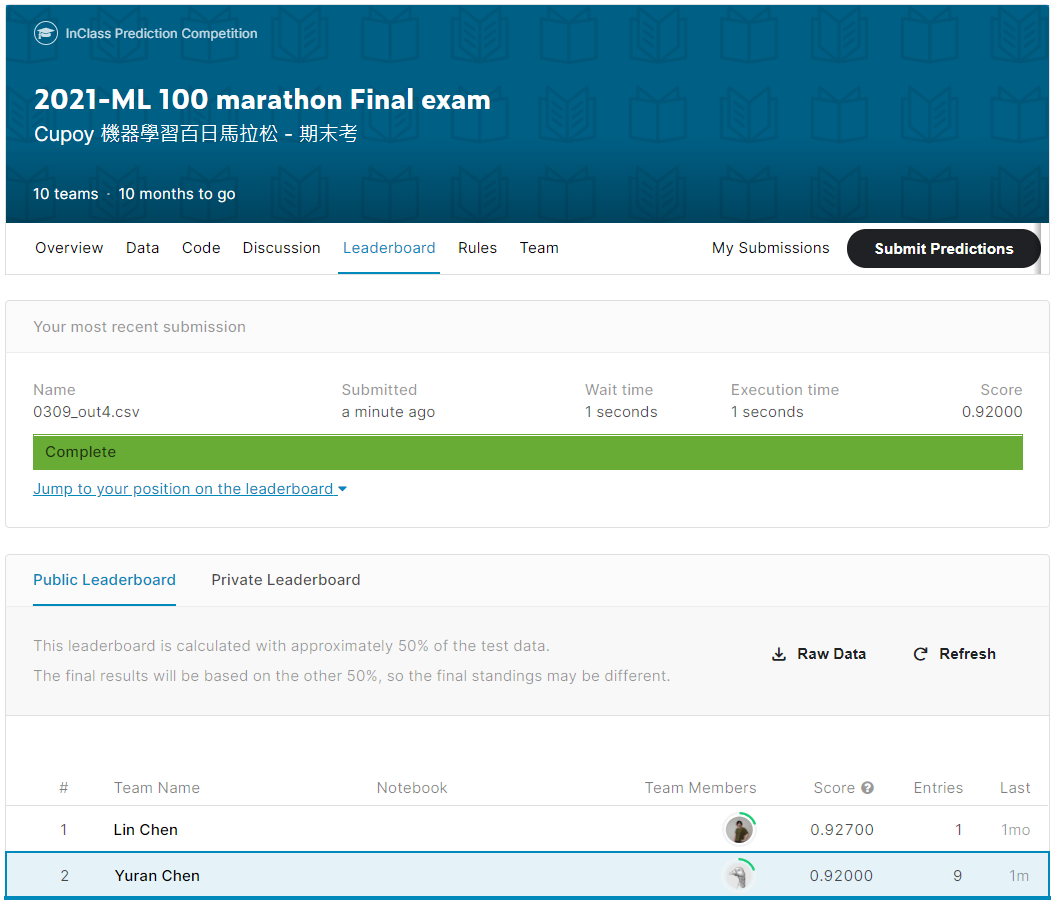

## Data Reading

In [1]:
import cv2
import copy
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

製作label

In [2]:
path = '/content/drive/MyDrive/ColabWorkBench/MLMarathon/Final_Exam/train'
names = os.listdir(path) # names = ['daisy', 'dandelion', 'tulip', 'rose', 'sunflower']
class_map = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}


all_file = [[]]*5
name_list = []
for i , name in enumerate(names):
  tmp = os.path.join(path, name)
  tmp_dir = glob(tmp+'/*.jpg')
  all_file[i] = all_file[i]+tmp_dir
  print(f'{len(tmp_dir)} images of {name}')

  for i in range(len(tmp_dir)):
    name_list.append(name)


label = pd.DataFrame(copy.deepcopy(name_list))
label[0] = label[0].map(class_map) 
label = np.array(label)


# 轉為one-hot encoding
label_onehot = keras.utils.to_categorical(label, num_classes=5)
print('label: ',label_onehot[0:4,:])


500 images of daisy
687 images of dandelion
633 images of tulip
515 images of rose
488 images of sunflower
label:  [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


讀入圖片並resize成256 x 256 ( w x h )

In [3]:
size = 256

len(all_file)
img_paths = []

for i in all_file:
  img_paths += i

print(f'total images: {len(img_paths)}')

data_count = len(img_paths)

# 定義一個讀取及轉換尺寸的func
def read_img(img_path, target_size=(size, size)):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,target_size)
  return img


X = np.zeros((data_count, size, size, 3))

# 讀取資料
for i, path in tqdm(enumerate(img_paths), total=len(img_paths)):
  X[i] = read_img(path)

total images: 2823


In [4]:
# train/test split
x_train, x_test, y_train, y_test = train_test_split(X, label_onehot, test_size=0.10)
print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (2540, 256, 256, 3)
x_test shape: (283, 256, 256, 3)
y_train shape: (2540, 5)
y_test shape: (283, 5)


## Data Generator & Augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(        
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.5,        
        zoom_range=0.8,
        channel_shift_range=70,                 
        horizontal_flip=True)

datagen.fit(x_train)

## Model Building

In [6]:
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers

In [7]:
# 超參數&callbacks設定

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                factor=0.5, 
                patience=5, 
                verbose=1, 
                min_lr=1e-7 )

check_point = ModelCheckpoint('/content/drive/MyDrive/ColabWorkBench/MLMarathon/Final_Exam/final_exam.h5',
                monitor='val_accuracy', 
                save_best_only=True)

early_stop = EarlyStopping(monitor='val_accuracy',
              restore_best_weights=True, 
              patience=18)


LR = 0.001


In [8]:
base_model = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(size, size, 3),pooling='max' ) # weights='imagenet'
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(base_model.input, predictions)


94773248/94765736 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Model Training

In [10]:
keras.backend.clear_session()

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=LR),
              metrics=['accuracy'])



logs = model.fit(datagen.flow(x_train, y_train, batch_size=64),
          steps_per_epoch=x_train.shape[0]//64,
          epochs=80,
          verbose=1,
          callbacks=[reduce_lr, check_point, early_stop],
          shuffle=True,    
          validation_data=(x_test, y_test),
          )

Epoch 1/80
39/39 [==============================] - 57s 910ms/step - loss: 5.8478 - accuracy: 0.3783 - val_loss: 619.8174 - val_accuracy: 0.2403
Epoch 2/80
39/39 [==============================] - 35s 901ms/step - loss: 1.1162 - accuracy: 0.5908 - val_loss: 15.7509 - val_accuracy: 0.3251
Epoch 3/80
39/39 [==============================] - 34s 878ms/step - loss: 0.8706 - accuracy: 0.6618 - val_loss: 1.7039 - val_accuracy: 0.6749
Epoch 4/80
39/39 [==============================] - 36s 914ms/step - loss: 0.6984 - accuracy: 0.7375 - val_loss: 1.9069 - val_accuracy: 0.5760
Epoch 5/80
39/39 [==============================] - 35s 903ms/step - loss: 0.6195 - accuracy: 0.7819 - val_loss: 1.8952 - val_accuracy: 0.5018
Epoch 6/80
39/39 [==============================] - 34s 883ms/step - loss: 0.6477 - accuracy: 0.7565 - val_loss: 1.2934 - val_accuracy: 0.6325
Epoch 7/80
39/39 [==============================] - 35s 887ms/step - loss: 0.5800 - accuracy: 0.7957 - val_loss: 0.7583 - val_accuracy: 0.7

Text(0.5, 1.0, 'Accuracy')

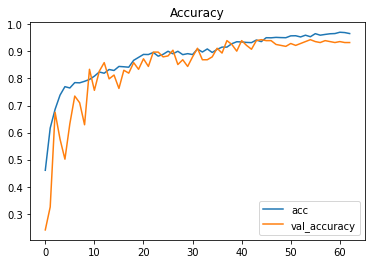

In [12]:
history = logs.history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['acc', 'val_accuracy'])
plt.title('Accuracy')



Text(0.5, 1.0, 'Loss')

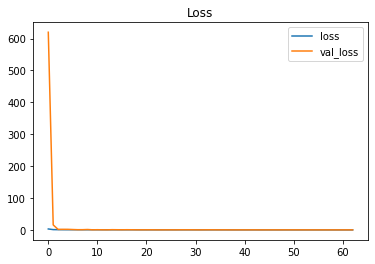

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')

## model prediction

In [14]:
path = '/content/drive/MyDrive/ColabWorkBench/MLMarathon/Final_Exam/test'


# 讀取各圖片實體位置
img_list = glob(path+'/*.jpg')

total_test_img_count = len(img_list)
print(f'total test images: {total_test_img_count}')

# 以id_list儲存個圖片id
id_list = [img_list[x].replace('.jpg','').split('/')[-1] for x in range(len(img_list))]
id_list[0:5]


total test images: 2000


['6fb51691c97de91a56443ce0222eae8c',
 '8a6d7e3f8916ba7ae018aba23639d2b1',
 '8573a379f364f2fa9a711c7209a4677b',
 '80d37af852072d74d19a0a2265f1ed49',
 '77d9856d4edaf31a4b2f483e2391b584']

In [15]:
# 讀取測試集圖片
X_test = np.zeros((total_test_img_count, size, size, 3))
for i, path in tqdm(enumerate(img_list), total=len(img_list)):
  X_test[i] = read_img(path) # read & resize to target pixels

In [16]:
# model prediction

pred_one_hot = model.predict(X_test)

pred_lab = np.argmax(pred_one_hot, axis=1)

ans = pd.DataFrame({'id':id_list,'flower_class':pred_lab})
ans.head(5)

,id,flower_class
0,6fb51691c97de91a56443ce0222eae8c,3
1,8a6d7e3f8916ba7ae018aba23639d2b1,1
2,8573a379f364f2fa9a711c7209a4677b,2
3,80d37af852072d74d19a0a2265f1ed49,1
4,77d9856d4edaf31a4b2f483e2391b584,4


In [17]:
ans.to_csv('/content/drive/MyDrive/ColabWorkBench/MLMarathon/Final_Exam/0309_out4.csv', index=False)